# Gathering

In [197]:
import pandas as pd
import numpy as np
import tweepy
import requests
import re
import json
import matplotlib.pyplot as plt
import datetime
import os
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
% matplotlib inline

In [198]:
archive_df = pd.read_csv('twitter-archive-enhanced.csv')

In [199]:
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [200]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [201]:
archive_df.name.value_counts()

None         745
a             55
Charlie       12
Oliver        11
Lucy          11
Cooper        11
Tucker        10
Penny         10
Lola          10
Bo             9
Winston        9
Sadie          8
the            8
Daisy          7
Bailey         7
an             7
Buddy          7
Toby           7
Jack           6
Milo           6
Koda           6
Rusty          6
Oscar          6
Dave           6
Leo            6
Jax            6
Stanley        6
Bella          6
Scout          6
Bentley        5
            ... 
Wafer          1
Sky            1
Reptar         1
Spanky         1
Mitch          1
Tug            1
Doobert        1
Sage           1
Gordon         1
Kaiya          1
Zuzu           1
space          1
Jerome         1
Autumn         1
Harrison       1
Zeus           1
Edd            1
Beebop         1
Marvin         1
Snicku         1
Grizzwald      1
Timofy         1
Kaia           1
Shadoe         1
Berkeley       1
Eleanor        1
O              1
Kevon         

In [202]:
archive_df.tweet_id.sort_values()

2355    666020888022790149
2354    666029285002620928
2353    666033412701032449
2352    666044226329800704
2351    666049248165822465
2350    666050758794694657
2349    666051853826850816
2348    666055525042405380
2347    666057090499244032
2346    666058600524156928
2345    666063827256086533
2344    666071193221509120
2343    666073100786774016
2342    666082916733198337
2341    666094000022159362
2340    666099513787052032
2339    666102155909144576
2338    666104133288665088
2337    666268910803644416
2336    666273097616637952
2335    666287406224695296
2334    666293911632134144
2333    666337882303524864
2332    666345417576210432
2331    666353288456101888
2330    666362758909284353
2329    666373753744588802
2328    666396247373291520
2327    666407126856765440
2326    666411507551481857
               ...        
29      886366144734445568
28      886680336477933568
27      886736880519319552
26      886983233522544640
25      887101392804085760
24      887343217045368832
2

In [203]:
image_predictions_df = pd.read_csv('image-predictions.tsv', sep = '\t')
image_predictions_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [204]:
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [205]:
# Downloading and saving the image prediction data using Requests
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
image = url.split('/')[-1]
response = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
if not os.path.isfile('image'):
    with open(image, 'wb') as f:
        f.write(response.content)

df_image = pd.read_csv('image-predictions.tsv', sep='\t')

In [206]:
image_predictions_df.tweet_id.value_counts()

685532292383666176    1
826598365270007810    1
692158366030913536    1
714606013974974464    1
715696743237730304    1
776477788987613185    1
772114945936949249    1
699775878809702401    1
780858289093574656    1
700462010979500032    1
732726085725589504    1
738883359779196928    1
798644042770751489    1
743510151680958465    1
837012587749474308    1
833722901757046785    1
668620235289837568    1
842765311967449089    1
685315239903100929    1
673686845050527744    1
680473011644985345    1
666051853826850816    1
675853064436391936    1
693231807727280129    1
705475953783398401    1
829449946868879360    1
759923798737051648    1
667160273090932737    1
680934982542561280    1
743545585370791937    1
                     ..
794926597468000259    1
776113305656188928    1
825026590719483904    1
834209720923721728    1
775733305207554048    1
669564461267722241    1
879492040517615616    1
720775346191278080    1
666362758909284353    1
750506206503038976    1
6931556864910008

In [207]:
image_predictions_df.sum()

tweet_id                               1532286567543998047538
jpg_url     https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jp...
img_num                                                  2498
p1          Welsh_springer_spanielredboneGerman_shepherdRh...
p1_conf                                               1233.69
p1_dog                                                   1532
p2          collieminiature_pinschermalinoisredboneRottwei...
p2_conf                                               279.271
p2_dog                                                   1553
p3          Shetland_sheepdogRhodesian_ridgebackbloodhound...
p3_conf                                               125.173
p3_dog                                                   1499
dtype: object

In [208]:
df_list = []

with open('tweet-json.txt', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        fav_count = tweet['favorite_count']
        df_list.append({'tweet_id':tweet_id,
                       'retweet_count': retweet_count,
                       'favorite_count': fav_count})
        
api_df = pd.DataFrame(df_list)

In [209]:
api_df[api_df.favorite_count.duplicated()]

,favorite_count,retweet_count,tweet_id
35,0,19297,885311592912609280
67,0,7181,879130579576475649
72,0,1349,878404777348136964
73,0,6965,878316110768087041
77,0,83,877611172832227328
90,0,15546,874434818259525634
94,0,12518,873697596434513921
96,0,1667,873337748698140672
100,0,31,872668790621863937
108,0,5991,871166179821445120


In [210]:
api_df

,favorite_count,retweet_count,tweet_id
0,39467,8853,892420643555336193
1,33819,6514,892177421306343426
2,25461,4328,891815181378084864
3,42908,8964,891689557279858688
4,41048,9774,891327558926688256
5,20562,3261,891087950875897856
6,12041,2158,890971913173991426
7,56848,16716,890729181411237888
8,28226,4429,890609185150312448
9,32467,7711,890240255349198849


In [211]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
tweet_id          2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


# Assessing

# Quality:

Archive_df:
- Time Satmp in archive_df contains two different information(hour and day date)
- There are several values that are not dog name such as "a".
- n_reply_to_status_id  & in_reply_to_user_id columns are not complete
-	tweet_id should be string not int because no calculations will be performed on it.
-	in_reply_to_status_id should be string
-	time stamp should be date not object
-	In most cases, the dog is not chosen as any of the four classes identified
-	The name is not extracted correctly as the value counts does not make any sense. They are extracted wrong because no dog is called a or Charlie
-	The max in rating numerator is a very large number(maybe invalid)
-	rating_numerator could be changed to float

Image_predictions_df:
- ID should be object not integer ot float. 	
- tweet_id should be string not int
- Lots of value duplicated

Api_df:
-	There are duplicates in Api_df.




# Tidiness:


- The 4  columns doggo, floofer, pupper and puppo identify the dog category, so they can be collected in one column.
- Tweet ID is duplicated between archive_df and api_df
- There are common columns among the 3 DFs, so they may be combined together in on DF

# Cleaning:

In [212]:
archive_df_clean = archive_df.copy()

In [213]:
image_predictions_df_clean = image_predictions_df.copy()

In [214]:
api_df_clean = api_df.copy()

# Define:

Treaing missing Data

In [215]:
archive_df_clean = pd.concat([archive_df_clean],
                             ignore_index=True)

# Test:

In [216]:
archive_df_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


# Define:

In archive_df, the day date and hour are combined in one column

Code:

In [217]:
archive_df_clean['date'] = pd.to_datetime(archive_df_clean['timestamp']).dt.date
archive_df_clean['time'] = pd.to_datetime(archive_df_clean['timestamp']).dt.time
archive_df_clean = archive_df_clean.drop('timestamp', axis=1)

# Test:

In [218]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
date                          2356 non-null object
time                          23

In [219]:
list(archive_df_clean)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'date',
 'time']

# Define:

favorite count in archive_df_clean is float not string

# Code:

In [220]:
api_df_clean.favorite_count = api_df_clean.favorite_count.astype(str).str[:-2].str.pad(5, fillchar='0')
# Reconvert NaNs entries that were converted to '0000n' by code above
api_df_clean.favorite_count = api_df_clean.favorite_count.replace('0000n', np.nan)

# Test:

In [221]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
date                          2356 non-null object
time                          23

# Define:

Merging the breed dog columns in archive_df_clean table

# Code:

In [222]:
archive_df_clean.replace('None', ' ', inplace=True)

In [223]:
archive_df_clean['dog_breed'] = archive_df_clean['pupper'] + archive_df_clean['puppo'] + archive_df_clean['doggo'] + archive_df_clean['floofer'] 

In [224]:
archive_df_clean = archive_df_clean.drop('pupper', axis=1)
archive_df_clean = archive_df_clean.drop('puppo', axis=1)
archive_df_clean = archive_df_clean.drop('doggo', axis=1)
archive_df_clean = archive_df_clean.drop('floofer', axis=1)

In [225]:
archive_df_clean.replace(' ', 'np.nan', inplace=True)

# Test:

In [226]:
archive_df_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,date,time,dog_breed
0,892420643555336193,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,2017-08-01,16:23:56,
1,892177421306343426,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,2017-08-01,00:17:27,
2,891815181378084864,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,2017-07-31,00:18:03,
3,891689557279858688,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,2017-07-30,15:58:51,
4,891327558926688256,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,2017-07-29,16:00:24,


# Define:

The rating numerator should be float not int

# Code:

In [227]:
archive_df_clean.rating_numerator  = archive_df_clean.rating_numerator.astype(float)

In [228]:
rating = archive_df_clean.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)
rating.columns = ['rating_numerator', 'rating_denominator']

# Test:

In [229]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null float64
rating_denominator            2356 non-null int64
name                          2356 non-null object
date                          2356 non-null object
time                          2356 non-null object
dog_breed                     2356 non-null object
dtypes: float64(5), int64(2), object(8)
memory usage: 276.2+ KB


# Define:

Merging the three data frames in one file

# Code:

In [230]:
archive_df_clean = pd.merge(archive_df_clean, api_df_clean, on=['tweet_id'], how='left')

In [231]:
archive_df_clean = pd.merge(archive_df_clean, image_predictions_df_clean,
                            on=['tweet_id'], how='left')

# Test:

In [232]:
list(archive_df_clean)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'date',
 'time',
 'dog_breed',
 'favorite_count',
 'retweet_count',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog']

In [233]:
archive_df_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13.0,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13.0,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12.0,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13.0,...,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12.0,...,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


# Define:

Creating rating column

# Code:

In [234]:
archive_df_clean['rating'] = archive_df_clean['rating_numerator'] / archive_df_clean['rating_denominator']

# Test:

In [235]:
archive_df_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,rating
0,892420643555336193,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13.0,...,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,1.3
1,892177421306343426,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13.0,...,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,1.3
2,891815181378084864,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12.0,...,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,1.2
3,891689557279858688,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13.0,...,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,1.3
4,891327558926688256,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12.0,...,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,1.2


In [236]:
archive_df_clean.to_csv ('twitter_archive_master1.csv', index = False, header=True)

# Data visualization

In [237]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 29 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null float64
rating_denominator            2356 non-null int64
name                          2356 non-null object
date                          2356 non-null object
time                          2356 non-null object
dog_breed                     2356 non-null object
favorite_count                2354 non-null object
retweet_count                 2354 non-null float64
jpg_url                      

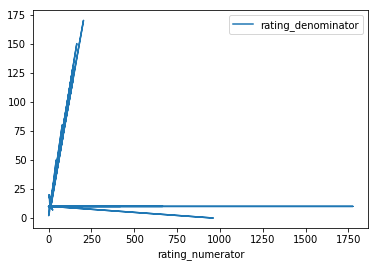

In [238]:
archive_df_clean.plot(x='rating_numerator', y='rating_denominator')

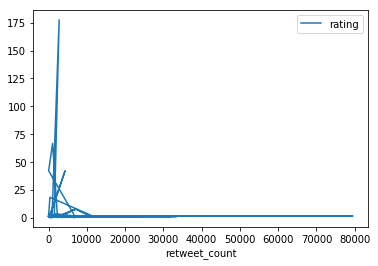

In [239]:
archive_df_clean.plot(x='retweet_count', y='rating')